In [34]:
!pip install timm wandb torch torchvision

In [35]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import timm
import numpy as np
import random
import os

In [36]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print(f"Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Using device: Tesla T4


In [37]:
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224, padding=28),
    transforms.RandomHorizontalFlip(),
    # REMOVED: AutoAugment - too aggressive for fine-tuning
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [38]:
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

# Split train into train+val (45k/5k split)
train_size = 45000
val_size = 5000
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

In [39]:
batch_size = 64  # Adjust based on GPU memory

train_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    shuffle=True, num_workers=2, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size,
    shuffle=False, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size,
    shuffle=False, num_workers=2, pin_memory=True
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 45000
Val samples: 5000
Test samples: 10000


In [40]:
model = timm.create_model(
    'vit_small_patch16_224',
    pretrained=True,
    num_classes=10,
    drop_rate=0.1,        # ADD: Dropout in classification head
    drop_path_rate=0.1    # ADD: Stochastic depth in transformer blocks
)

model = model.cuda()
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Total parameters: 21,669,514


In [41]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # ADD: Label smoothing

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,            # REDUCED from 3e-4 (3x lower)
    weight_decay=0.1    # INCREASED from 0.05 (2x higher)
)

# Simpler scheduler - just cosine decay, no warmup needed with lower LR
from torch.optim.lr_scheduler import CosineAnnealingLR

total_epochs = 50  # INCREASED: More epochs with lower LR
scheduler = CosineAnnealingLR(optimizer, T_max=total_epochs, eta_min=1e-6)

scaler = GradScaler()

print(f"Starting LR: {optimizer.param_groups[0]['lr']}")
print(f"Training for {total_epochs} epochs")

Starting LR: 0.0001
Training for 50 epochs


/tmp/ipython-input-2797215823.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [42]:
def train_epoch(model, loader, criterion, optimizer, scaler, device='cuda'):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed precision forward pass
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Scaled backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device='cuda'):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100. * correct / total


In [43]:
import os

checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [44]:
best_val_acc = 0.0

for epoch in range(total_epochs):
    print(f"\nEpoch {epoch+1}/{total_epochs}")
    print("-" * 50)

    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, scaler
    )

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion)

    # Step scheduler
    scheduler.step()

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'val_acc': val_acc,
        }
        torch.save(checkpoint, f'{checkpoint_dir}/best_model.pth')
        print(f"✓ Best model saved! Val Acc: {val_acc:.2f}%")

    # Save regular checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save(checkpoint, f'{checkpoint_dir}/checkpoint_epoch_{epoch+1}.pth')

print(f"\n🎉 Training complete! Best Val Accuracy: {best_val_acc:.2f}%")


Epoch 1/50
--------------------------------------------------


/tmp/ipython-input-2300312076.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.7376 | Train Acc: 91.22%
Val Loss: 0.6096 | Val Acc: 95.46%
LR: 0.000100
✓ Best model saved! Val Acc: 95.46%

Epoch 2/50
--------------------------------------------------
Train Loss: 0.6217 | Train Acc: 95.45%
Val Loss: 0.5888 | Val Acc: 96.10%
LR: 0.000100
✓ Best model saved! Val Acc: 96.10%

Epoch 3/50
--------------------------------------------------
Train Loss: 0.5968 | Train Acc: 96.36%
Val Loss: 0.5873 | Val Acc: 96.32%
LR: 0.000099
✓ Best model saved! Val Acc: 96.32%

Epoch 4/50
--------------------------------------------------
Train Loss: 0.5786 | Train Acc: 97.04%
Val Loss: 0.5783 | Val Acc: 96.68%
LR: 0.000098
✓ Best model saved! Val Acc: 96.68%

Epoch 5/50
--------------------------------------------------
Train Loss: 0.5723 | Train Acc: 97.28%
Val Loss: 0.5766 | Val Acc: 96.76%
LR: 0.000098
✓ Best model saved! Val Acc: 96.76%

Epoch 6/50
--------------------------------------------------
Train Loss: 0.5634 | Train Acc: 97.55%
Val Loss: 0.5907 | Val Acc: 96.

Loaded best model from epoch 48
Best validation accuracy: 98.34%

FINAL TEST ACCURACY: 98.10%
Test Loss: 0.5555

PER-CLASS PERFORMANCE:
              precision    recall  f1-score   support

    airplane     0.9929    0.9840    0.9884      1000
  automobile     0.9744    0.9880    0.9811      1000
        bird     0.9849    0.9790    0.9819      1000
         cat     0.9637    0.9550    0.9593      1000
        deer     0.9831    0.9870    0.9850      1000
         dog     0.9631    0.9660    0.9646      1000
        frog     0.9930    0.9950    0.9940      1000
       horse     0.9871    0.9930    0.9900      1000
        ship     0.9822    0.9910    0.9866      1000
       truck     0.9858    0.9720    0.9789      1000

    accuracy                         0.9810     10000
   macro avg     0.9810    0.9810    0.9810     10000
weighted avg     0.9810    0.9810    0.9810     10000



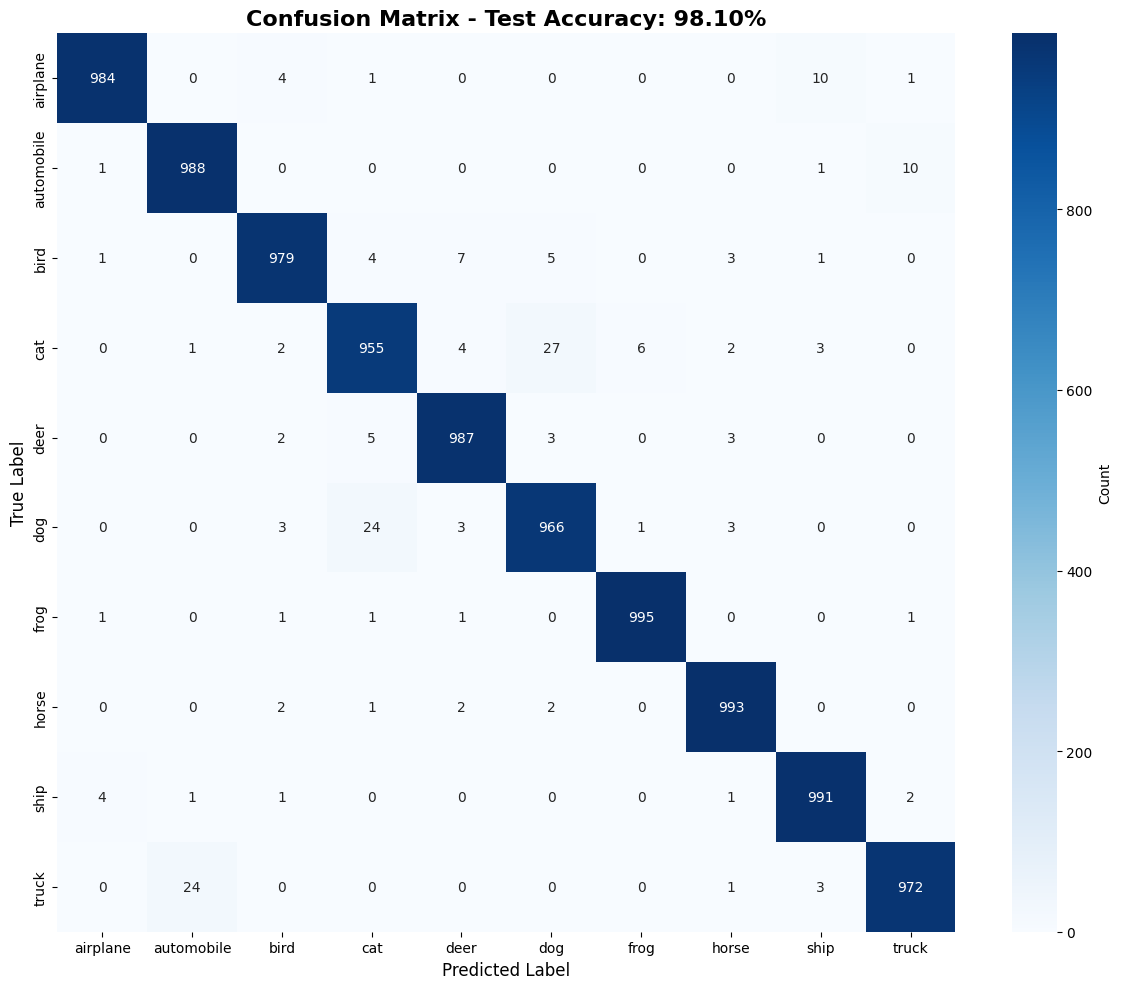


PER-CLASS ACCURACY:
airplane    :  98.40% ( 984/1000)
automobile  :  98.80% ( 988/1000)
bird        :  97.90% ( 979/1000)
cat         :  95.50% ( 955/1000)
deer        :  98.70% ( 987/1000)
dog         :  96.60% ( 966/1000)
frog        :  99.50% ( 995/1000)
horse       :  99.30% ( 993/1000)
ship        :  99.10% ( 991/1000)
truck       :  97.20% ( 972/1000)

 Best:  frog         - 99.50%
 Worst: cat          - 95.50%


In [45]:
# Cell: Load best model and evaluate on test set
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best checkpoint
checkpoint = torch.load(f'{checkpoint_dir}/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%\n")

# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"FINAL TEST ACCURACY: {test_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f}\n")

# Detailed per-class evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Classification report
print("="*60)
print("PER-CLASS PERFORMANCE:")
print("="*60)
print(classification_report(all_labels, all_preds,
                          target_names=classes,
                          digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - Test Accuracy: {test_acc:.2f}%', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(f'{checkpoint_dir}/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Per-class accuracy
class_correct = [0] * 10
class_total = [0] * 10

for pred, label in zip(all_preds, all_labels):
    if pred == label:
        class_correct[label] += 1
    class_total[label] += 1

print("\n" + "="*60)
print("PER-CLASS ACCURACY:")
print("="*60)
for i, class_name in enumerate(classes):
    acc = 100 * class_correct[i] / class_total[i]
    print(f"{class_name:12s}: {acc:6.2f}% ({class_correct[i]:4d}/{class_total[i]:4d})")

# Find best and worst performing classes
class_accs = [100 * class_correct[i] / class_total[i] for i in range(10)]
best_idx = class_accs.index(max(class_accs))
worst_idx = class_accs.index(min(class_accs))

print(f"\n Best:  {classes[best_idx]:12s} - {class_accs[best_idx]:.2f}%")
print(f" Worst: {classes[worst_idx]:12s} - {class_accs[worst_idx]:.2f}%")